## Problème du voyageur de commerce

In [1]:
import cvxpy as cp
import numpy as np
import math
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
import random
n=random.randint(10,50)
x = [ random.random() for _ in range(n) ]
y = [ random.random() for _ in range(n) ]


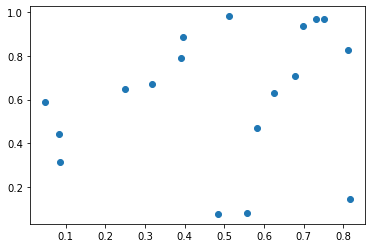

In [3]:
import matplotlib.pyplot as plt
plt.plot(x,y,"o")

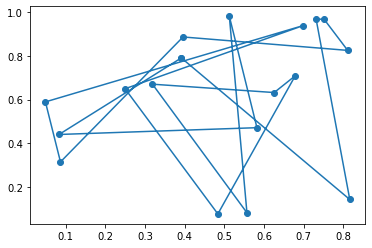

In [4]:
plt.plot(x + [ x[0] ], y + [ y[0] ], "o-")

In [5]:
def show_tsp(x, y, aretes=None):
    if aretes is None:
        aretes = []
    plt.scatter(x, y)
    for i, j in aretes:
        plt.plot([x[i], x[j]], [y[i], y[j]], color="red")
    plt.show()


In [6]:
def find_next(var_x, cur):
    n = len(var_x)
    for i in range(n):
        if var_x[cur][i] > 0.5:
            return i
    assert False

def find_subtour(var_x, start):
    n = len(var_x)
    cur = find_next(var_x, start)
    tour = [(start, cur)]
    while cur != start:
        nxt = find_next(var_x, cur)
        tour.append((cur, nxt))
        cur = nxt
    return tour

In [7]:
def solve_tsp(x, y, subtours=None):
    if subtours is None:
        subtours = []

    n = len(x)
    var_x = cp.Variable((n, n), boolean=True)

    obj_variables = []
    for i in range(n):
        for j in range(n):
            if i != j:
                dx = x[i] - x[j]
                dy = y[i] - y[j]
                dist = math.sqrt(dx**2 + dy**2)
                obj_variables.append(dist * var_x[i][j])
    objective = cp.Minimize(cp.sum(obj_variables))

    constraints = []

    for i in range(n):
        constraints.append(cp.sum(var_x[i,:]) - var_x[i,i] == 1)

    for i in range(n):
        constraints.append(cp.sum(var_x[:,i]) - var_x[i,i] == 1)

    for i in range(n-1):
        for j in range(i + 1, n):
            constraints.append(var_x[i, j] + var_x[j, i] <= 1)

    for subtour in subtours:
        variables = []
        for i, j in subtour:
            variables.append(var_x[i, j])
        constraints.append(cp.sum(variables) <= len(variables) -1)

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CBC)

    tours = []
    found_tour = [False for i in range(n)]
    for i in range(n):
        if not found_tour[i]:
            tour = find_subtour(var_x.value, 0)
            for j, k in tour:
                found_tour[j] = True
            tours.append(tour)
    print(tours)
    
    aretes = []
    for i in range(n):
        for j in range(n):
            if i != j and var_x[i][j].value > 0.5:
                aretes.append((i, j))

    if len(tours) == 1:
        show_tsp(x, y, aretes)
    return tours






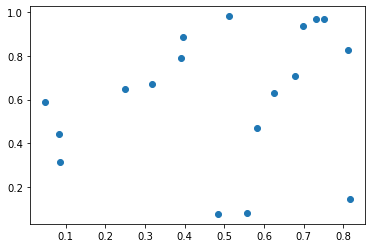

In [8]:
show_tsp(x, y)

[[(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)]]
[[(0, 13), (13, 3), (3, 10), (10, 16), (16, 15), (15, 14), (14, 7), (7, 6), (6, 2), (2, 9), (9, 5), (5, 0)], [(0, 13), (13, 3), (3, 10), (10, 16), (16, 15), (15, 14), (14, 7), (7, 6), (6, 2), (2, 9), (9, 5), (5, 0)], [(0, 13), (13, 3), (3, 10)

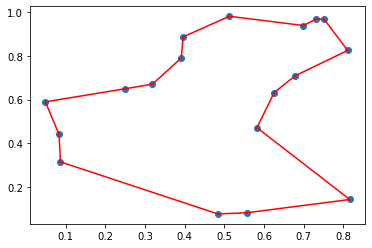

In [9]:
all_subtours = []
while True:
    subtours = solve_tsp(x, y, all_subtours)
    if len(subtours) == 1:
        break
    all_subtours.extend(subtours)

### Modélisation et ajout de contraintes 

In [10]:
def solve_tsp(x, y, subtours=None):
    if subtours is None:
        subtours = []

    n = len(x)
    var_x = cp.Variable((n, n), boolean=True)
    u = cp.Variable(n, integer=True)
    ones = np.ones((n,1))

    obj_variables = []
    for i in range(n):
        for j in range(n):
            if i != j:
                dx = x[i] - x[j]
                dy = y[i] - y[j]
                dist = math.sqrt(dx**2 + dy**2)
                obj_variables.append(dist * var_x[i][j])
    objective = cp.Minimize(cp.sum(obj_variables))

    constraints = []
    constraints += [var_x @ ones == ones]
    constraints += [var_x.T @ ones == ones]
    constraints += [cp.diag(var_x) == 0]
    constraints += [u[1:] >= 2]
    constraints += [u[1:] <= n]
    constraints += [u[0] == 1]

    for i in range(n):
        constraints.append(cp.sum(var_x[i,:]) - var_x[i,i] == 1)

    for i in range(n):
        constraints.append(cp.sum(var_x[:,i]) - var_x[i,i] == 1)

    for i in range(n-1):
        for j in range(i + 1, n):
            constraints.append(var_x[i, j] + var_x[j, i] <= 1)

    for subtour in subtours:
        variables = []
        for i, j in subtour:
            variables.append(var_x[i, j])
        constraints.append(cp.sum(variables) <= len(variables) -1)

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CBC)

    tours = []
    found_tour = [False for i in range(n)]
    for i in range(n):
        if not found_tour[i]:
            tour = find_subtour(var_x.value, 0)
            for j, k in tour:
                found_tour[j] = True
            tours.append(tour)
    print(tours)
    
    aretes = []
    for i in range(n):
        for j in range(n):
            if i != j and var_x[i][j].value > 0.5:
                aretes.append((i, j))

    if len(tours) == 1:
        show_tsp(x, y, aretes)
    return tours



[[(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)], [(0, 5), (5, 9), (9, 2), (2, 6), (6, 7), (7, 14), (14, 15), (15, 16), (16, 10), (10, 3), (3, 13), (13, 0)]]
[[(0, 13), (13, 3), (3, 10), (10, 16), (16, 15), (15, 14), (14, 7), (7, 6), (6, 2), (2, 9), (9, 5), (5, 0)], [(0, 13), (13, 3), (3, 10), (10, 16), (16, 15), (15, 14), (14, 7), (7, 6), (6, 2), (2, 9), (9, 5), (5, 0)], [(0, 13), (13, 3), (3, 10)

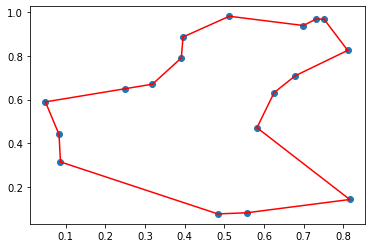

In [11]:
all_subtours = []
while True:
    subtours = solve_tsp(x, y, all_subtours)
    if len(subtours) == 1:
        break
    all_subtours.extend(subtours)

### Impleméntation d'affichage avec map réel Folium

Pour cette partie , le but c'est d'ecrire le code qui permet d'amleiorer l'affichage d'une maniére différente et plus réel.
Pour cela , j'ai chosi des villes francaises , j'ai travaillé avec geopandas pour récupere le map de la france ainsi pour récupere les coordonées de chaque ville que j'ai mis dans une liste.
Ensuite , j'ai utilisé le solver utilisé lors de tp , mais j'ai travaillé sur une autre fonction show_tsp en utilisant le Folium qui est outil de visualisation puisque cette bibliothèque rend possible la conception de cartes interactives.


In [1]:
import geopandas as gpd
import networkx as nx
import geopy
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.approximation as nx_app
import math
from geopy.geocoders import Nominatim
import folium
%matplotlib inline
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings(action = "ignore")

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math





In [3]:
def get_coordinates(place):
    place_details = geolocator.geocode(place)
    
    coordinates = (place_details[1][0], place_details[1][1])
    
    return coordinates[1], coordinates[0]


<AxesSubplot:>

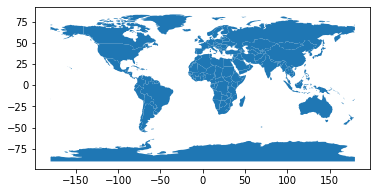

In [4]:

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.plot()


In [5]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "app")

capitals = ['Lille', 'Paris', 'Rouen','Le Havre','Troyes','Reims','Angers','Rennes','Poitiers','La Rochelle','Limoges','Belfort']


#Initialise empty list to get coordinates of each city
coordinates = []

for capital in capitals:
    globals()["%s_coordinate"%capital] = get_coordinates(capital)
    coordinates.append(globals()["%s_coordinate"%capital])
    
coordinates


[(3.0635282, 50.6365654),
 (2.3200410217200766, 48.8588897),
 (1.0939658, 49.4404591),
 (0.1079732, 49.4938975),
 (4.0746257, 48.2971626),
 (4.031926, 49.2577886),
 (-0.5515588, 47.4739884),
 (-1.6800198, 48.1113387),
 (0.340196, 46.5802596),
 (-1.1520434, 46.1591126),
 (1.2644847, 45.8354243),
 (6.8628942, 47.6379599)]

<AxesSubplot:>

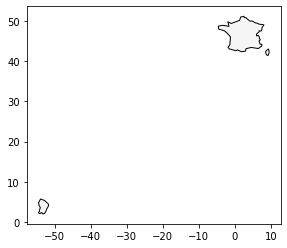

In [6]:

france = world[world.name == "France"]
france.plot(color = "whitesmoke", edgecolor = "black")

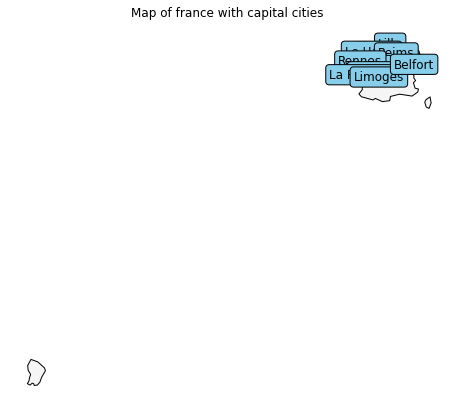

In [9]:
G = nx.Graph()
#Create a graph object with number of nodes same as number of cities
nodes = np.arange(0, len(capitals))
G.add_nodes_from(nodes)

#Create a dictionary of node and coordinate of each state for positions
positions = {node:coordinate for node, coordinate in zip(nodes, coordinates)}

#Create a dictionary of node and capital for labels
labels = {node:capital for node, capital in zip(nodes, capitals)}

fig, ax = plt.subplots(figsize = (10, 7))
france.plot(color = "whitesmoke", edgecolor = "black", ax = ax)
nx.draw_networkx(G, pos = positions,
                 labels = labels, ax = ax,
                 bbox = dict(facecolor = "skyblue", boxstyle = "round",
                             ec = "black", pad = 0.3),)

plt.title("Map of france with capital cities ")
plt.axis("off")
plt.show()

In [10]:
x=[]
y=[]
i=0
for X, Y in coordinates:
    x.append(X)
    y.append(Y)
    i+=1
print(x)
n=len(x)
print(n)

[3.0635282, 2.3200410217200766, 1.0939658, 0.1079732, 4.0746257, 4.031926, -0.5515588, -1.6800198, 0.340196, -1.1520434, 1.2644847, 6.8628942]
12


In [11]:

def show_tsp(x, y,coordinates, aretes=None):
    if aretes is None:
        aretes = []

    pos = {node:list(coordinate) for node, coordinate in zip(nodes, coordinates)}

    for i in range(len(pos)):
        for j in range(i + 1, len(pos)):
        
            dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
            G.add_edge(i, j, weight=dist)

    cycle = nx_app.christofides(G, weight="weight")

    edge_list = list(nx.utils.pairwise(cycle))
    folium_coordinates = []
    for x,y in coordinates:
        folium_coordinates.append([y,x])
    
    route = []
    for stop in cycle:
        route.append(folium_coordinates[stop])
    
    m1 = folium.Map(location = [51, 10],   
                tiles = "OpenStreetMap", 
                zoom_start= 6
                )

    for coordinate, capital in zip(folium_coordinates, capitals):
        folium.Marker(location = coordinate,
                 popup = capital).add_to(m1)
    
    folium.PolyLine(route).add_to(m1)
    
    display(m1)
        


In [12]:

def find_next(var_x, cur):
    n = len(var_x)
    for i in range(n):
        if var_x[cur][i] > 0.5:
            return i
    assert False

def find_subtour(var_x, start):
    n = len(var_x)
    cur = find_next(var_x, start)
    tour = [(start, cur)]
    while cur != start:
        nxt = find_next(var_x, cur)
        tour.append((cur, nxt))
        cur = nxt
    return tour


def solve_tsp(x, y,n ,coordinates, subtours=None):
    if subtours is None:
        subtours = []

    n = n
    var_x = cp.Variable((n, n), boolean=True)

    obj_variables = []
    for i in range(n):
        for j in range(n):
            if i != j:
                dx = x[i] - x[j]
                dy = y[i] - y[j]
                dist = math.sqrt(dx**2 + dy**2)
                obj_variables.append(dist * var_x[i][j])
    objective = cp.Minimize(cp.sum(obj_variables))

    constraints = []

    for i in range(n):
        constraints.append(cp.sum(var_x[i,:]) - var_x[i,i] == 1)

    for i in range(n):
        constraints.append(cp.sum(var_x[:,i]) - var_x[i,i] == 1)

    for i in range(n-1):
        for j in range(i + 1, n):
            constraints.append(var_x[i, j] + var_x[j, i] <= 1)

    for subtour in subtours:
        variables = []
        for i, j in subtour:
            variables.append(var_x[i, j])
        constraints.append(cp.sum(variables) <= len(variables) -1)

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CBC)

    tours = []
    found_tour = [False for i in range(n)]
    for i in range(n):
        if not found_tour[i]:
            tour = find_subtour(var_x.value, 0)
            for j, k in tour:
                found_tour[j] = True
            tours.append(tour)
    print(tours)
    
    aretes = []
    for i in range(n):
        for j in range(n):
            if i != j and var_x[i][j].value > 0.5:
                aretes.append((i, j))

    if len(tours) == 1:
        show_tsp(x, y,coordinates, aretes)
    return tours

In [13]:
all_subtours = []
while True:
    subtours = solve_tsp(x, y, n, coordinates,all_subtours)
    if len(subtours) == 1:
        break
    all_subtours.extend(subtours)


[[(0, 1), (1, 2), (2, 3), (3, 0)], [(0, 1), (1, 2), (2, 3), (3, 0)], [(0, 1), (1, 2), (2, 3), (3, 0)], [(0, 1), (1, 2), (2, 3), (3, 0)], [(0, 1), (1, 2), (2, 3), (3, 0)], [(0, 1), (1, 2), (2, 3), (3, 0)], [(0, 1), (1, 2), (2, 3), (3, 0)], [(0, 1), (1, 2), (2, 3), (3, 0)], [(0, 1), (1, 2), (2, 3), (3, 0)]]
[[(0, 3), (3, 2), (2, 1), (1, 0)], [(0, 3), (3, 2), (2, 1), (1, 0)], [(0, 3), (3, 2), (2, 1), (1, 0)], [(0, 3), (3, 2), (2, 1), (1, 0)], [(0, 3), (3, 2), (2, 1), (1, 0)], [(0, 3), (3, 2), (2, 1), (1, 0)], [(0, 3), (3, 2), (2, 1), (1, 0)], [(0, 3), (3, 2), (2, 1), (1, 0)], [(0, 3), (3, 2), (2, 1), (1, 0)]]
[[(0, 2), (2, 3), (3, 1), (1, 0)], [(0, 2), (2, 3), (3, 1), (1, 0)], [(0, 2), (2, 3), (3, 1), (1, 0)], [(0, 2), (2, 3), (3, 1), (1, 0)], [(0, 2), (2, 3), (3, 1), (1, 0)], [(0, 2), (2, 3), (3, 1), (1, 0)], [(0, 2), (2, 3), (3, 1), (1, 0)], [(0, 2), (2, 3), (3, 1), (1, 0)], [(0, 2), (2, 3), (3, 1), (1, 0)]]
[[(0, 1), (1, 3), (3, 2), (2, 0)], [(0, 1), (1, 3), (3, 2), (2, 0)], [(0, 1), (